# EDA of textual canary data

## Load necessary libraries and funtions

In [66]:
import pandas as pd
import sys
import os
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from sklearn.metrics.pairwise import euclidean_distances


In [11]:
sys.path.append(
  os.path.abspath(os.path.join(os.path.dirname('data_loader.py'), os.path.pardir)))
from src.data.data_loader import DataLoader

In [17]:
loc_dict = {
    'train': '../data/raw/canary/set_B_train_kw.csv',
    'val': '../data/raw/canary/set_B_val_kw.csv',
    'test': '../data/raw/canary/set_B_test_kw.csv'
}
data_loader = DataLoader(loc_dict)

In [18]:
print(os.getcwd())

D:\Users\bergr2\PycharmProjects\ArticleClassifier\notebooks


## load training data

In [56]:
train_data_df = data_loader.load_train_data()
train_subset_df = train_data_df.iloc[:5000]

In [89]:
print(train_data_df)
label_columns = train_data_df.loc[:, ~train_data_df.columns.isin(['input_raw', 'input', 'pui'])]

              pui                                          input_raw  \
0       632365149  What Is the Prevalence of Measles Immunity amo...   
1      2010597070  AAV-mediated inhibition of ULK1 promotes axona...   
2      2010362398  Extreme and gradual rainfall effects on winter...   
3      2011548670  Mismatch repair deficiency occurs very rarely ...   
4      2005052350  Overview of research development on the role o...   
...           ...                                                ...   
75502  2011551254  Relationship between body condition score inde...   
75503  2007320232  Surgical reconstruction of nonunion after iatr...   
75504  2007044801  Molecular detection of hemotropic mycoplasmas ...   
75505  2007469180  Identification of lung and blood microbiota im...   
75506  2003451804  Increased risk of malignancy in patients aged ...   

                                                   input  human  \
0      prevalence measles immunity among pregnant wom...      1   
1

## embed documents with d2v

In [25]:
documents = [TaggedDocument(doc, [i]) for i, doc in train_data_df[['input']].iterrows()]

In [62]:
model = Doc2Vec(documents, vector_size=128, window=5, min_count=1, workers=4)

In [67]:
embedded_docs = np.array([model.dv[i] for i, doc in train_subset_df[['input']].iterrows()])

In [68]:
embedded_docs

array([[-0.00409752, -0.0046772 , -0.00773972, ...,  0.00053657,
        -0.00518894, -0.00061657],
       [ 0.00205749, -0.00599528,  0.00311292, ..., -0.00178444,
        -0.00183784,  0.00494215],
       [ 0.00351639,  0.0040692 ,  0.00205429, ..., -0.00095124,
        -0.00677522,  0.00560691],
       ...,
       [-0.00069037, -0.00490598, -0.00701373, ..., -0.00533214,
         0.00599393,  0.00544323],
       [-0.00163701, -0.00620274, -0.00128458, ..., -0.00505757,
         0.00474776,  0.00209061],
       [ 0.00268079,  0.00531614,  0.0051138 , ...,  0.00319518,
        -0.00108489, -0.00737195]], dtype=float32)

## use TSNE to plot embeddings

In [69]:
fashion_tsne = TSNE(random_state=42, n_jobs=-1, verbose=3, n_iter=500).fit_transform(embedded_docs)

SyntaxError: invalid syntax (3743765925.py, line 1)

In [60]:
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 [Text(-0.055493366, -1.2313032, '0'), Text(-1.3514988, 1.1751497, '1')])

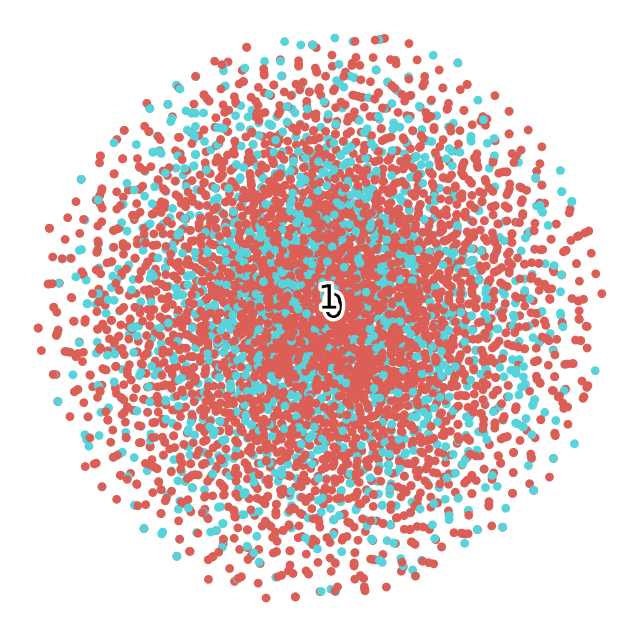

In [61]:
fashion_scatter(fashion_tsne, train_subset_df['major clinical study'])

## create semantic network

In [70]:
embedded_docs_df

dists = euclidean_distances(embedded_docs,embedded_docs)



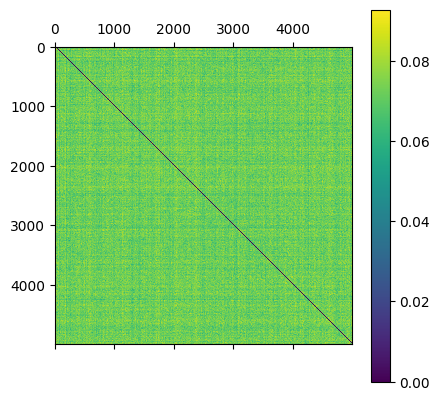

In [73]:
plt.matshow(dists)
plt.colorbar()

In [78]:
# generate a semantic simarity network
semantic_network_df = pd.DataFrame(columns=['article_id', 'outgoing_links'])
links = dists > 0.07
print(links)
semantic_network_df['article_id'] = train_subset_df['pui']
print(np.where(links == True))
semantic_network_df['outgoing_links'] = np.where(links == True)

[[False  True  True ...  True  True  True]
 [ True False  True ... False False  True]
 [ True  True False ... False False  True]
 ...
 [ True False False ... False False  True]
 [ True False False ... False False  True]
 [ True  True  True ...  True  True False]]
(array([   0,    0,    0, ..., 4999, 4999, 4999], dtype=int64), array([   1,    2,    4, ..., 4996, 4997, 4998], dtype=int64))


ValueError: Length of values (2) does not match length of index (5000)

## KNN on d2v embeddings

In [97]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix


ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (c:\program files\python39\lib\site-packages\sklearn\metrics\__init__.py)

In [100]:
knn = KNeighborsClassifier(n_neighbors=7)
for label in label_columns:
    knn.fit(embedded_docs, train_subset_df[label])
    predictions = knn.predict(embedded_docs)
    print(f"Confusion matrix for {label}: \n", confusion_matrix(predictions, train_subset_df[label]))
    print(f'The recall score: {recall_score(predictions, train_subset_df[label])}')
    
#     color = 'white'
#     matrix = plot_confusion_matrix(knn, embedded_docs, train_subset_df[label], cmap=plt.cm.Blues)
#     matrix.ax_.set_title('Confusion Matrix', color=color)
#     plt.xlabel('Predicted Label', color=color)
#     plt.ylabel('True Label', color=color)
#     plt.gcf().axes[0].tick_params(colors=color)
#     plt.gcf().axes[1].tick_params(colors=color)
#     plt.show()

Confusion matrix for human: 
 [[ 296  169]
 [1121 3414]]
The recall score: 0.7528114663726571
Confusion matrix for controlled study: 
 [[1102  667]
 [ 980 2251]]
The recall score: 0.6966883317858248
Confusion matrix for major clinical study: 
 [[3229 1053]
 [ 297  421]]
The recall score: 0.5863509749303621
Confusion matrix for clinical article: 
 [[4128  799]
 [  32   41]]
The recall score: 0.5616438356164384
Confusion matrix for mouse: 
 [[4566  430]
 [   2    2]]
The recall score: 0.5
Confusion matrix for case report: 
 [[4651  348]
 [   0    1]]
The recall score: 1.0
Confusion matrix for rat: 
 [[4780  220]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for randomized controlled trial: 
 [[4811  188]
 [   0    1]]
The recall score: 1.0
Confusion matrix for clinical trial: 
 [[4865  135]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for multicenter study: 
 [[4885  115]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for diagnostic test accuracy study: 
 [[4889  111]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for systematic review: 
 [[4920   80]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for double blind procedure: 
 [[4947   53]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for meta analysis: 
 [[4944   56]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for controlled clinical trial: 
 [[4985   15]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for crossover procedure: 
 [[4983   17]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for phase 2 clinical trial: 
 [[4972   28]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for single blind procedure: 
 [[4988   12]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for phase 3 clinical trial: 
 [[4989   11]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for phase 1 clinical trial: 
 [[4989   11]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for phase 4 clinical trial: 
 [[4999    1]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for male: 
 [[1506  767]
 [ 944 1783]]
The recall score: 0.6538320498716539
Confusion matrix for female: 
 [[1378  732]
 [1009 1881]]
The recall score: 0.6508650519031142
Confusion matrix for adult: 
 [[2160  984]
 [ 675 1181]]
The recall score: 0.6363146551724138
Confusion matrix for aged: 
 [[3954  875]
 [  77   94]]
The recall score: 0.5497076023391813
Confusion matrix for middle aged: 
 [[4341  624]
 [  14   21]]
The recall score: 0.6
Confusion matrix for child: 
 [[4642  353]
 [   2    3]]
The recall score: 0.6
Confusion matrix for adolescent: 
 [[4681  318]
 [   0    1]]
The recall score: 1.0
Confusion matrix for young adult: 
 [[4845  154]
 [   0    1]]
The recall score: 1.0
Confusion matrix for very elderly: 
 [[4852  148]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for infant: 
 [[4880  120]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for school child: 
 [[4901   99]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for newborn: 
 [[4901   99]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for preschool child: 
 [[4915   85]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for embryo: 
 [[4939   61]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for fetus: 
 [[4978   22]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for nonhuman: 
 [[3173 1150]
 [ 248  429]]
The recall score: 0.6336779911373708
Confusion matrix for animal experiment: 
 [[4264  693]
 [  22   21]]
The recall score: 0.4883720930232558
Confusion matrix for animal tissue: 
 [[4487  502]
 [   4    7]]
The recall score: 0.6363636363636364
Confusion matrix for animal model: 
 [[4471  517]
 [   5    7]]
The recall score: 0.5833333333333334
Confusion matrix for animal cell: 
 [[4631  366]
 [   0    3]]
The recall score: 1.0
Confusion matrix for human cell: 
 [[4413  563]
 [  11   13]]
The recall score: 0.5416666666666666
Confusion matrix for human tissue: 
 [[4455  521]
 [   7   17]]
The recall score: 0.7083333333333334
Confusion matrix for normal human: 
 [[4927   73]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for human experiment: 
 [[4926   74]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for observational study: 
 [[4797  203]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for pilot study: 
 [[4943   57]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for longitudinal study: 
 [[4924   76]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for retrospective study: 
 [[4402  570]
 [  12   16]]
The recall score: 0.5714285714285714
Confusion matrix for case control study: 
 [[4928   72]
 [   0    0]]
The recall score: 0.0


c:\program files\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for cohort analysis: 
 [[4400  575]
 [  12   13]]
The recall score: 0.52
Confusion matrix for cross-sectional study: 
 [[4709  288]
 [   1    2]]
The recall score: 0.6666666666666666
